# 2. Tree-Based Methods

### (a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/ APS+Failure+at+Scania+Trucks# . The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.linear_model import LinearRegression,LassoCV,Ridge,Lasso,RidgeCV
from sklearn.model_selection import train_test_split,cross_val_score,validation_curve,KFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,scale
from sklearn import metrics
from sklearn.decomposition import PCA
import random
random.seed(5)
import weka.core.jvm as jvm
jvm.start()
from weka.classifiers import Classifier
import weka.core.converters as converters
import weka.plot.classifiers as plcls 
from imblearn.over_sampling import SMOTE
from weka.classifiers import Evaluation
from weka.core.classes import Random
from sklearn.ensemble import RandomForestClassifier

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/abhinavreddy/anaconda3/lib/python3.5/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/abhinavreddy/anaconda3/lib/python3.5/site-packages/javabridge/jars/runnablequeue.jar', '/Users/abhinavreddy/anaconda3/lib/python3.5/site-packages/javabridge/jars/cpython.jar', '/Users/abhinavreddy/anaconda3/lib/python3.5/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/abhinavreddy/anaconda3/lib/python3.5/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled
DEBUG:javabridge.jutil:Creating JVM object
DEBUG:javabridge.jutil:Launching VM in non-python thread
DEBUG:javabridge.jutil:Attaching to VM in monitor thread
DEBUG:javabridge.jutil:Signalling caller
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
trainset=pd.read_csv("aps_failure_training_set.csv")
testset=pd.read_csv("aps_failure_test_set.csv")


In [3]:
trainset=trainset.replace('na',np.nan)
testset=testset.replace('na',np.nan)
trainset.iloc[:,1:]=(trainset.iloc[:,1:]).apply(pd.to_numeric, errors='coerce')
testset.iloc[:,1:]=(testset.iloc[:,1:]).apply(pd.to_numeric, errors='coerce')

In [4]:
xtrain=trainset.drop(['class'],axis=1)
ytrain=trainset['class']
xtest=testset.drop(['class'],axis=1)
ytest=testset['class']
ytrain=ytrain.replace({'neg':0,'pos':1})
ytest=ytest.replace({'neg':0,'pos':1})

<br/><br/>
### (b) Data Preparation This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea. i. Research what types of techniques are usually used for dealing with data with missing values.1 Pick at least one of them and apply it to this data in the next steps.2

First method is  to use Central Imputation using mean, median or mode. Below the mean is used to replace the missing value.

In [5]:
xtrain.fillna(xtrain.mean(),inplace=True)
xtest.fillna(xtrain.mean(),inplace=True)

The approaches usually adopted for data  imputation are:<br/>
1)A constant value that has meaning within the domain, such as 0.<br/>
2) A measure of Central Tendency such as mean,median or mode. <br/>
3) A value estimated from another predictor model such as MICE. This method assumes the missing value of an attribute as dependent variable and other attributes as independent variables and performs Modelling and estimates the values.

<br/><br/>
### ii. For each of the 170 features, calculate the coefficient of variation CV = s/m, where s is sample variance and m is sample mean.

In [24]:
ty=xtrain.std()/xtrain.mean()
print("The coefficient of Variation are\n",ty.sort_values(ascending=False)[:20])

The coefficient of Variation are
 cs_009    235.277605
cf_000    184.233092
co_000    183.949017
ad_000    183.847620
dh_000    114.984991
dj_000    109.647285
ag_000     91.878565
as_000     86.416904
ay_009     83.786063
az_009     76.967978
ak_000     74.526688
au_000     68.160554
ch_000     58.268229
ay_001     52.233852
dz_000     49.002158
df_000     48.799015
cs_008     47.682310
ef_000     47.124953
aj_000     43.801822
eg_000     40.553250
dtype: float64


<br/><br/>
### iii. Plot a correlation matrix for your features using pandas or any other tool.



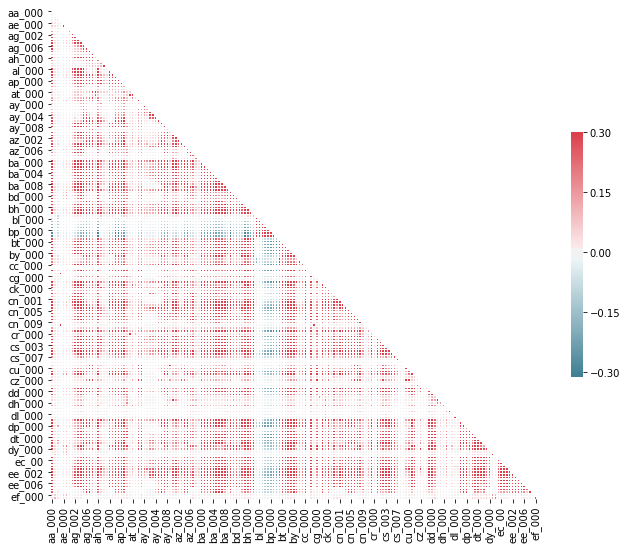

In [25]:
mask = np.zeros_like(xtrain.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(xtrain.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<br/><br/>
### iv. Pick √170c features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots?

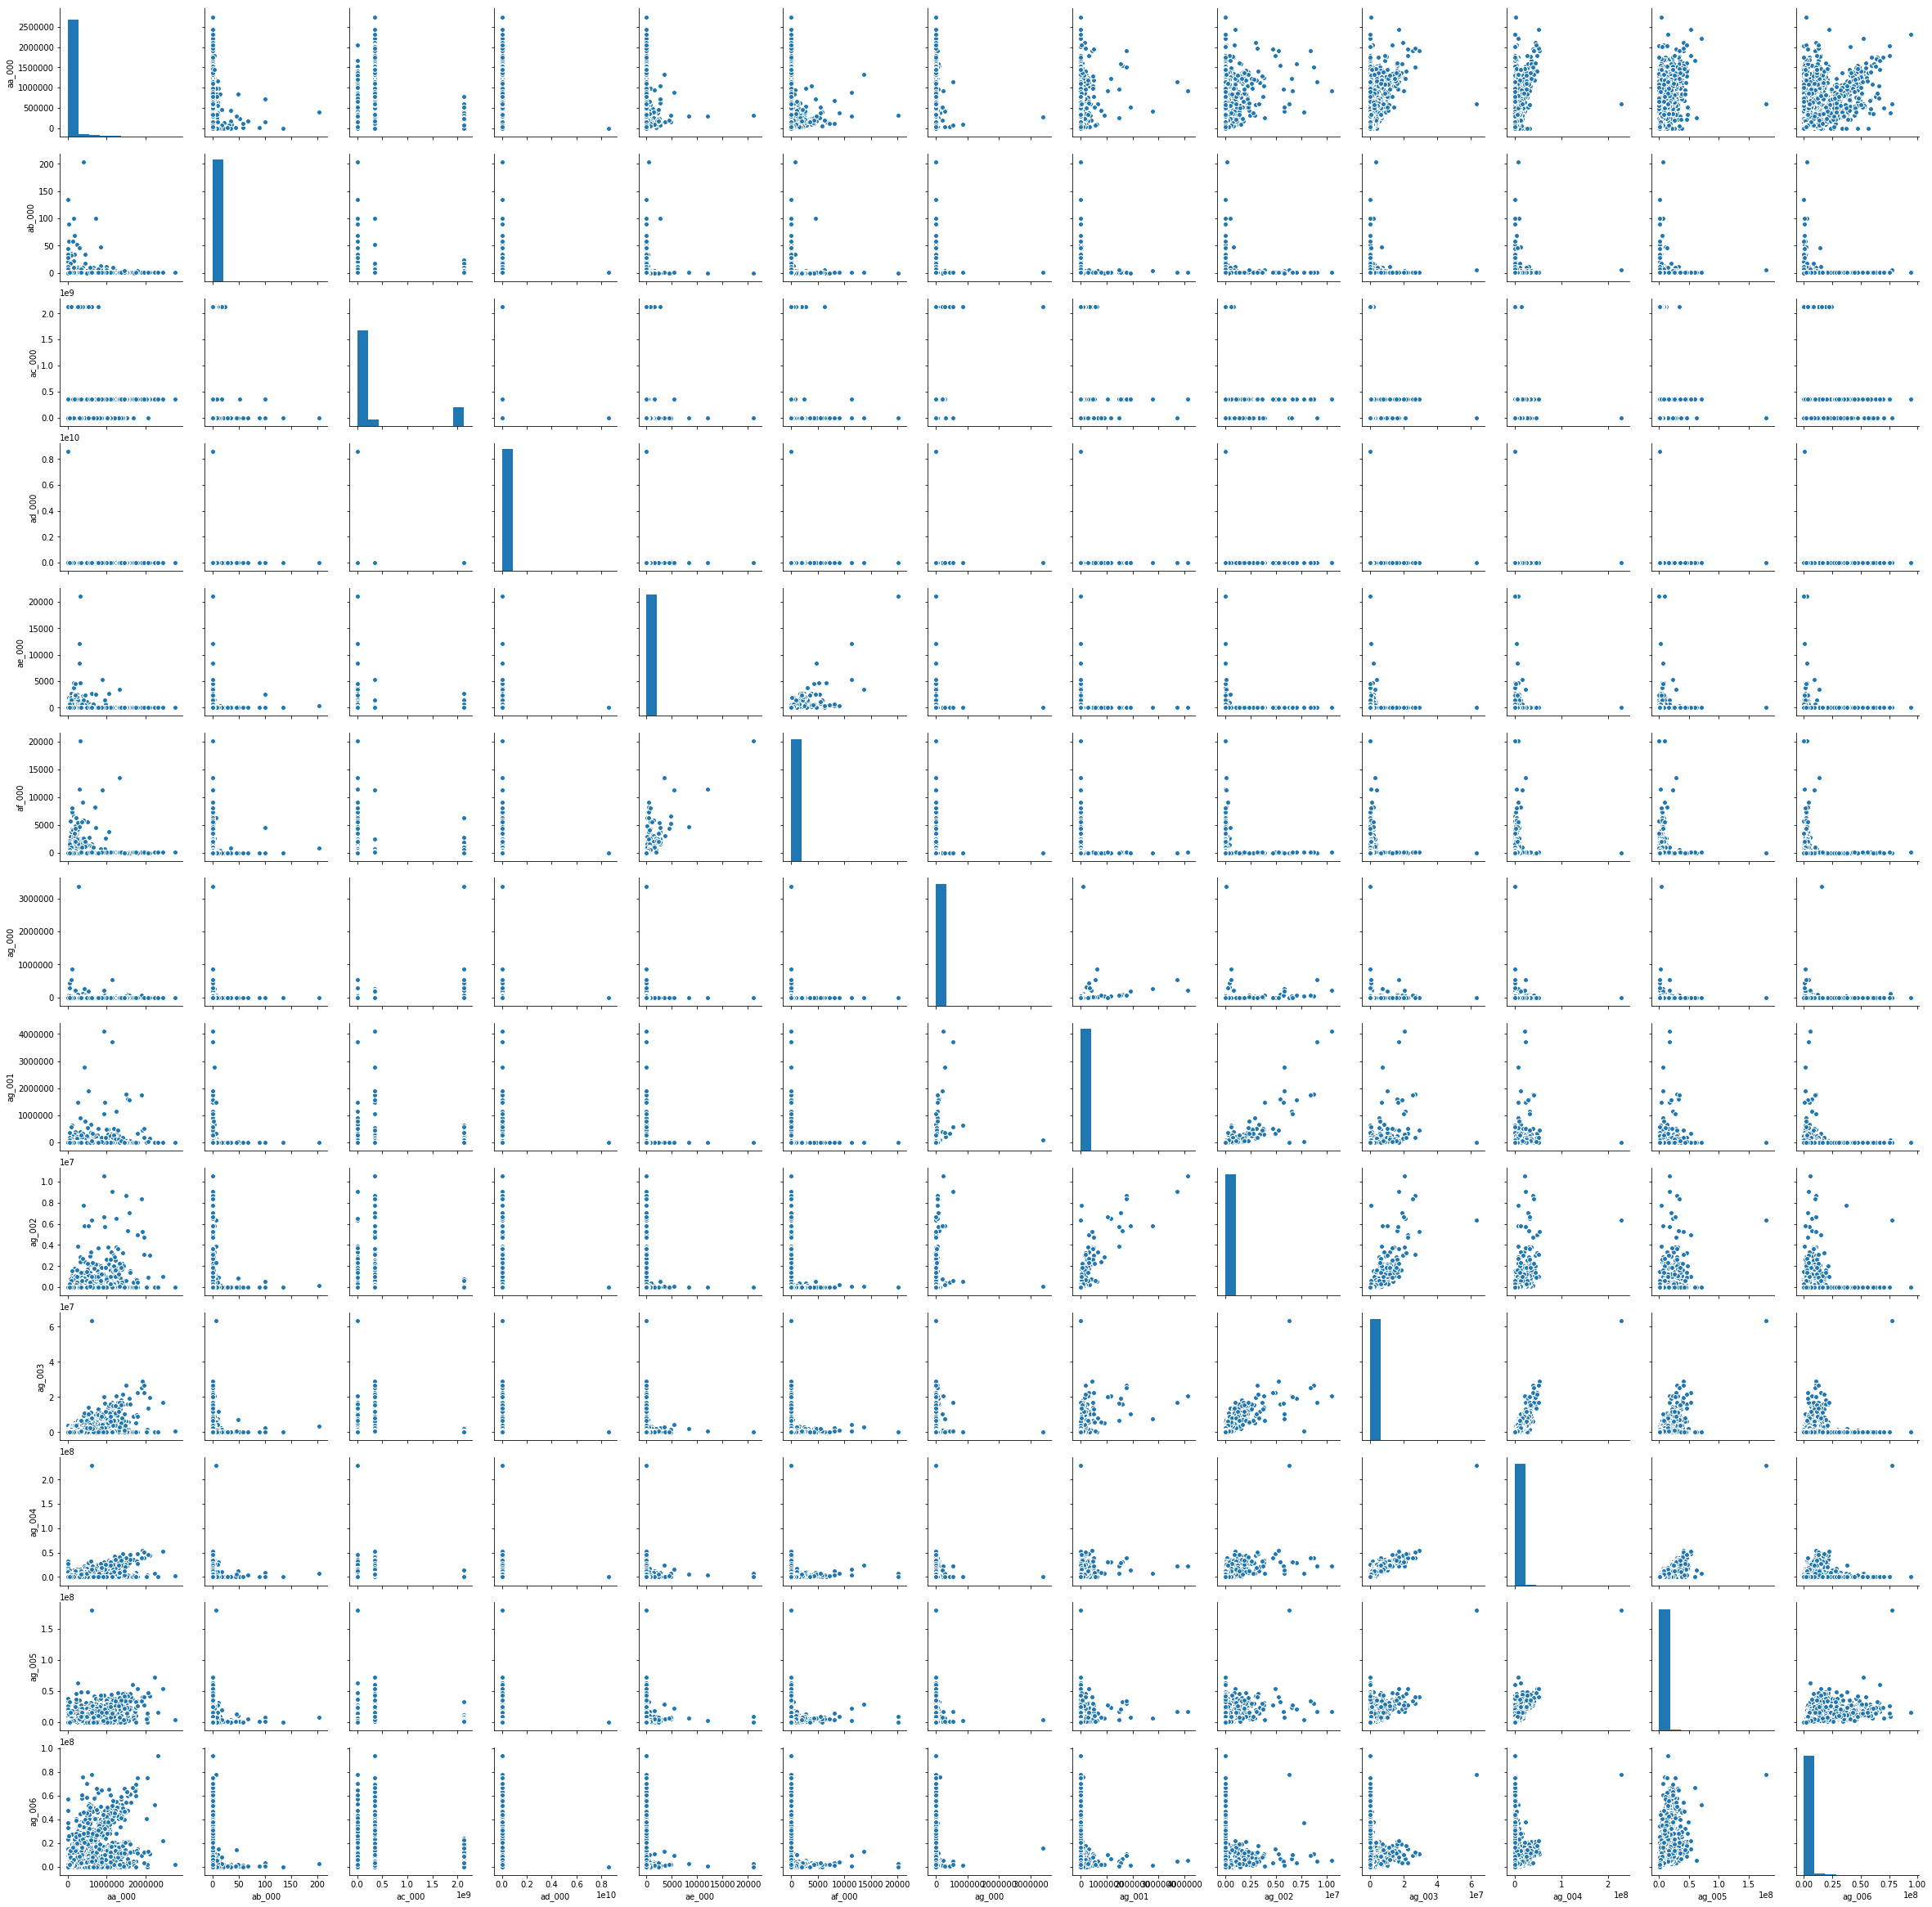

In [26]:
lj=np.array(ty.index[:13])
sns.pairplot(xtrain[lj])

I have plotted only 1 Boxplot because these images take a lot of space 


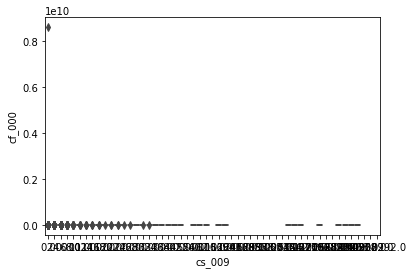

In [16]:
sns.boxplot(x='cs_009',y='cf_000',data=xtrain)
print('I have plotted only 1 Boxplot because these images take a lot of space ')


From the scatter plots we can just determine the Correlation between the features and their distribution .

The significance of those features cannot be interpreted just by scatter plots because there might be a third variable explaining the relationship between two variables.(Confounding variables)

<br/><br/>
### v. Determine the number of positive and negative data. Is this data set imbalanced?

In [26]:
y=pd.concat([ytrain,ytest],axis=0)
y=y.replace({0:'neg',1:'pos'})
y.value_counts()

neg    74625
pos     1375
Name: class, dtype: int64

Yes, the set is imbalanced as the Negative instances dominate the dataset.

<br/><br/>
### c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [76]:
mod_imb=RandomForestClassifier(oob_score=True)
mod_imb.fit(xtrain,ytrain)
ypred_rand=mod_imb.predict(xtest)
ypred_tr1=mod_imb.predict(xtrain)
print('The Confusion matrix is \n',metrics.confusion_matrix(ytest,ypred_rand))

/Users/abhinavreddy/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/abhinavreddy/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


The Confusion matrix is 
 [[15608    17]
 [  129   246]]


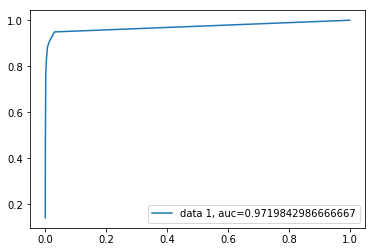

In [77]:
y_pred_proba = mod_imb.predict_proba(xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [78]:
print('The AUC is ',auc)

The AUC is  0.9719842986666667


In [79]:
print('The ROC  is ',fpr,tpr,_)

The ROC  is  [0.0000e+00 6.4000e-05 2.5600e-04 6.4000e-04 1.0880e-03 1.4720e-03
 3.6480e-03 7.0400e-03 1.2800e-02 3.0208e-02 1.0000e+00] [0.14133333 0.30666667 0.44266667 0.552      0.656      0.76
 0.82933333 0.88266667 0.90666667 0.94933333 1.        ] [1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 0. ]


In [82]:
print('The train error is ',1-metrics.accuracy_score(ytrain,ypred_tr1))

The train error is  0.0006000000000000449


In [52]:
print("The test error is ",1-metrics.accuracy_score(ytest,ypred_rand))

The test error is  0.009062499999999973


In [53]:
print("The out of Bag error is ",1-mod_imb.oob_score_)

The out of Bag error is  0.008916666666666684


The out of Bag Error is Slightly lower than test error. It is determined by building the model with all observations except one and testing with the removed observations.

<br/><br/>
### (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

In [83]:
mod_imb1=RandomForestClassifier(oob_score=True,class_weight='balanced')
mod_imb1.fit(xtrain,ytrain)
ypred_rand1=mod_imb1.predict(xtest)
ypred_tr=mod_imb1.predict(xtrain)
print('The Confusion matrix is \n',metrics.confusion_matrix(ytest,ypred_rand1))

/Users/abhinavreddy/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/abhinavreddy/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


The Confusion matrix is 
 [[15607    18]
 [  175   200]]


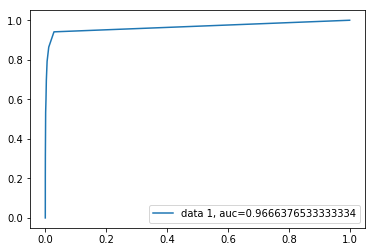

In [84]:
y_pred_proba1 = mod_imb1.predict_proba(xtest)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(ytest,  y_pred_proba1)
auc1 = metrics.roc_auc_score(ytest, y_pred_proba1)
plt.plot(fpr1,tpr1,label="data 1, auc="+str(auc1))
plt.legend(loc=4)
plt.show()


In [71]:
print('The AUC is ',auc1)

The AUC is  0.9629910186666666


In [72]:
print('The ROC  is ',fpr1,tpr1,_)

The ROC  is  [0.0000e+00 6.4000e-05 1.2800e-04 3.2000e-04 7.6800e-04 1.8560e-03
 3.0720e-03 5.6960e-03 1.0112e-02 2.7456e-02 1.0000e+00] [0.11466667 0.20533333 0.30133333 0.408      0.512      0.624
 0.72       0.79733333 0.85333333 0.93333333 1.        ] [1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 0. ]


In [86]:
print("The test error is ",1-metrics.accuracy_score(ytest,ypred_rand1))

The test error is  0.012062499999999976


In [87]:
print('The training error is ',1-metrics.accuracy_score(ytrain,ypred_tr))

The training error is  0.0007000000000000339


In [88]:
print("The out of Bag error is ",1-mod_imb1.oob_score_)

The out of Bag error is  0.009950000000000014


**Comparison**<br/>
The test error is higher with the Balanced Random Forest. Also, the out of Bag error is also higher. The AUC is lower. 

<br/>
<br/>
### e) Model Trees In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has PjβjXj > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node. One of the methods that can be used at each node is Logistic Regression. One can use scikit learn to call Weka to train Logistic Model Trees for classification. Train Logistic Model Trees for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [11]:
bro=pd.read_csv('train1.csv')
bro=bro.loc[:10000,:]
bro.to_csv('train2.csv',index=False)

In [2]:
import weka.core.jvm as jvm
jvm.start()
from weka.classifiers import Classifier


INFO:weka.core.jvm:JVM already running, call jvm.stop() first


In [3]:
import weka.core.converters as converters
tr_data = converters.load_any_file('train2.csv')
tr_data.class_is_last()
tt_data = converters.load_any_file('test1.csv')
tt_data.class_is_last()


In [4]:
mod_weka=Classifier(classname='weka.classifiers.trees.LMT')
mod_weka.build_classifier(tr_data)

In [5]:
from weka.classifiers import Evaluation
from weka.core.classes import Random
evl = Evaluation(tt_data)
evl.crossvalidate_model(mod_weka, tr_data, 5, Random(1))
print(evl.test_model(mod_weka,tt_data))
print(evl.percent_correct)
print(evl.summary())
print(evl.class_details())

[0. 0. 0. ... 0. 0. 0.]
98.80389215799393

Correctly Classified Instances       25690               98.8039 %
Incorrectly Classified Instances       311                1.1961 %
Kappa statistic                          0.6833
Mean absolute error                      0.0163
Root mean squared error                  0.097 
Relative absolute error                 39.9541 %
Root relative squared error             66.215  %
Total Number of Instances            26001     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.395    0.991      0.997    0.994      0.690    0.974     0.998     neg
                 0.605    0.003    0.800      0.605    0.689      0.690    0.974     0.734     pos
Weighted Avg.    0.988    0.386    0.987      0.988    0.987      0.690    0.974     0.992     



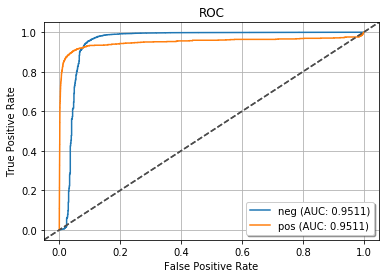

In [52]:
import weka.plot.classifiers as plcls  # NB: matplotlib is required
plcls.plot_roc(evl, class_index=[0, 1], wait=True)

In [91]:
print('The Accuracy is around 99.028% for the SMOTE model',"The area under curve is 0.9511",'The ROC curve is plotted above.')

The Accuracy is around 99.028% for the SMOTE model The area under curve is 0.9511 The ROC curve is plotted above.


In [7]:
print('The confusion matrix is \n',evl.confusion_matrix)

The confusion matrix is 
 [[25345.    86.]
 [  225.   345.]]


<br/><br/>
### (f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance. Train a Logistic Model Tree using the pre-processed data and repeat 2e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE.

In [14]:
mf=SMOTE(kind='regular')
x_tr,y_tr=mf.fit_sample(xtrain[:30000],ytrain.replace({0:'neg',1:'pos'})[:30000])
gt=pd.concat([pd.DataFrame(x_tr),pd.Series(y_tr)],axis=1)
gt.columns=bro.columns
gt.to_csv('train3.csv',index=False)

In [15]:
gt.shape

(58922, 171)

In [16]:
tr_data1 = converters.load_any_file('train3.csv')
tr_data1.class_is_last()
tt_data1 = converters.load_any_file('test1.csv')
tt_data1.class_is_last()

In [17]:
mod_weka1=Classifier(classname='weka.classifiers.trees.LMT')
mod_weka1.build_classifier(tr_data1)

In [18]:
evl = Evaluation(tt_data1)
evl.crossvalidate_model(mod_weka1, tr_data1, 5, Random(1))
print(evl.test_model(mod_weka1,tt_data1))
print(evl.percent_correct)
print(evl.summary())
print(evl.class_details())


[0. 0. 0. ... 0. 0. 0.]
98.39833426763835

Correctly Classified Instances       73722               98.3983 %
Incorrectly Classified Instances      1200                1.6017 %
Kappa statistic                          0.9667
Mean absolute error                      0.0247
Root mean squared error                  0.1149
Relative absolute error                  4.9347 %
Root relative squared error             22.9788 %
Total Number of Instances            74922     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.982    0.013    0.992      0.982    0.987      0.967    0.995     0.996     neg
                 0.987    0.018    0.973      0.987    0.980      0.967    0.995     0.989     pos
Weighted Avg.    0.984    0.015    0.984      0.984    0.984      0.967    0.995     0.993     



DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/abhinavreddy/anaconda3/lib/python3.5/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/abhinavreddy/anaconda3/lib/python3.5/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


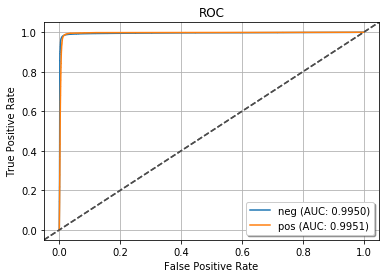

In [19]:
plcls.plot_roc(evl, class_index=[0, 1], wait=True)

In [89]:
print('The Accuracy is around 98.39% for the SMOTE model',"The area under curve is 0.9950",'The ROC curve is plotted above.')

The Accuracy is around 98.39%


In [92]:
print('The confusion matrix for SMOTE trained model is \n',evl.confusion_matrix)

The confusion matrix for SMOTE trained model is 
 [[44264.   822.]
 [  378. 29458.]]


**Comparison**<br/>
The area under curve increased with the SMOTE model. Also,the classification accuracy decreased with the SMOTE model.